#Import Data

In [5]:
#Impor Pustaka
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Pra-pemrosesan & Pemodelan
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Model Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Mengatur Tampilan & Peringatan
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')



In [6]:
# Menggunakan kagglehub.dataset_load() yang lebih baru
try:
    data = pd.read_csv('/kaggle/input/hotel-reservations-classification-dataset/Hotel Reservations.csv')
    print("Data loaded from local path.")
except FileNotFoundError:
    print("Local file not found, loading from Kaggle Hub...")
    import kagglehub
    from kagglehub import KaggleDatasetAdapter
    file_path = ""
    data = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS,
                                  "ahsan81/hotel-reservations-classification-dataset",'Hotel Reservations.csv')

print("Dimensi data:", data.shape)
print("\nContoh data:")
print(data.head())

Data loaded from local path.
Dimensi data: (36275, 19)

Contoh data:
  Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN00001             2               0                     1   
1   INN00002             2               0                     2   
2   INN00003             1               0                     2   
3   INN00004             2               0                     0   
4   INN00005             2               0                     1   

   no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                  2       Meal Plan 1                           0   
1                  3      Not Selected                           0   
2                  1       Meal Plan 1                           0   
3                  2       Meal Plan 1                           0   
4                  1      Not Selected                           0   

  room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0        Room_Type 1   

#Data Exploration

In [7]:
#Analisis Data Eksploratif (EDA) - Pemeriksaan Awal
print("\nInfo Data Awal:")
data.info()


Info Data Awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11

In [8]:
print("\nPemeriksaan Nilai Kosong:")
print(data.isnull().sum())


Pemeriksaan Nilai Kosong:
Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64


In [9]:
# Mengganti nilai avg_price_per_room yang 0 dengan NaN lalu diisi median
data['avg_price_per_room'] = data['avg_price_per_room'].replace(0, np.nan)
median_price = data['avg_price_per_room'].median()
data['avg_price_per_room'].fillna(median_price, inplace=True)
print(f"\nNilai 0 pada 'avg_price_per_room' telah diganti dengan median: {median_price}")


Nilai 0 pada 'avg_price_per_room' telah diganti dengan median: 100.0


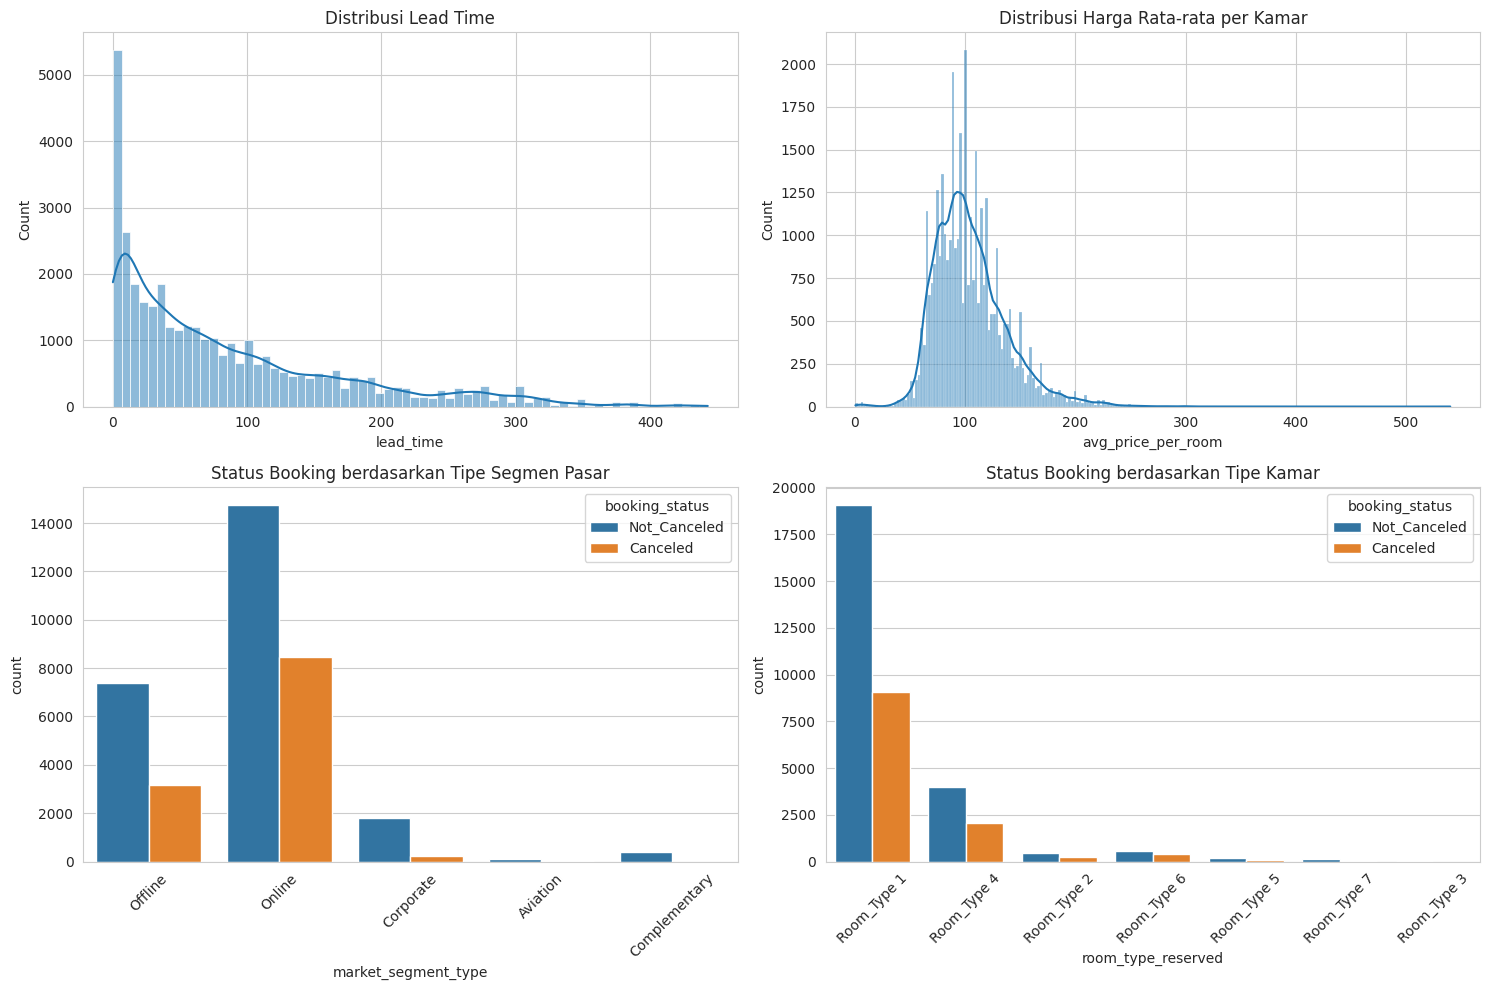

In [10]:
# EDA - Visualisasi
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(data['lead_time'], kde=True)
plt.title('Distribusi Lead Time')

plt.subplot(2, 2, 2)
sns.histplot(data['avg_price_per_room'], kde=True)
plt.title('Distribusi Harga Rata-rata per Kamar')

plt.subplot(2, 2, 3)
sns.countplot(x='market_segment_type', hue='booking_status', data=data)
plt.title('Status Booking berdasarkan Tipe Segmen Pasar')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
sns.countplot(x='room_type_reserved', hue='booking_status', data=data)
plt.title('Status Booking berdasarkan Tipe Kamar')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Eksplorasi dan Persiapan Data (EDA & Preprocessing)

* **Kualitas Data** : Dataset yang digunakan berkualitas tinggi, terbukti dengan tidak adanya nilai kosong (null) pada seluruh kolom. Ini menyederhanakan tahap persiapan data secara signifikan.

* **Penanganan Outlier/Nilai Janggal**: Langkah cerdas dilakukan pada fitur `avg_price_per_room`. Nilai 0 pada kolom ini kemungkinan besar adalah anomali atau kesalahan input data (karena kamar gratis sangat tidak umum). Menggantinya dengan nilai median adalah pendekatan yang kuat dan lebih baik daripada menghapus baris data atau menggantinya dengan rata-rata, terutama jika ada outlier.

* **Wawasan dari Visualisasi**:

  * **Distribusi Fitur** : Visualisasi menunjukkan bahwa fitur seperti `lead_time` (jarak waktu antara pemesanan dan kedatangan) dan `avg_price_per_room` memiliki distribusi yang skewed (condong ke kanan), yang mengindikasikan bahwa sebagian besar pemesanan dilakukan dalam rentang waktu yang tidak terlalu jauh dari tanggal kedatangan dengan harga yang moderat.

  * **Korelasi dengan Pembatalan** : Plot menunjukkan bahwa segmen pasar "Online" memiliki proporsi pembatalan yang lebih tinggi dibandingkan segmen "Offline". Hal ini masuk akal, karena pemesanan online memberikan kemudahan untuk membatalkan. Tipe kamar tertentu juga menunjukkan tingkat pembatalan yang berbeda, menandakan bahwa fitur-fitur kategorikal ini penting untuk prediksi.

* **Pra-pemrosesan yang Robust**: Penggunaan Pipeline dan ColumnTransformer adalah praktik terbaik.

  * **RobustScaler** dipilih untuk fitur numerik, yang merupakan pilihan tepat mengingat adanya potensi outlier pada fitur seperti lead_time dan harga. Scaler ini tidak terlalu terpengaruh oleh nilai ekstrem.

  * **OneHotEncoder** digunakan untuk mengubah fitur kategorikal menjadi format numerik tanpa menciptakan urutan artifisial, yang sangat penting untuk model seperti Regresi Logistik.

# Pra-pemrosesan Data

In [11]:
# Menghapus Booking_ID dan mendefinisikan X dan y
data = data.drop('Booking_ID', axis=1)

In [12]:
# Mengubah target menjadi biner
le = LabelEncoder()
data['booking_status'] = le.fit_transform(data['booking_status']) # Not_Canceled -> 1, Canceled -> 0

X = data.drop('booking_status', axis=1)
y = data['booking_status']

In [13]:
# Memisahkan fitur numerik dan kategorikal
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

print("\nFitur Numerik:", numerical_features)
print("Fitur Kategorikal:", categorical_features)


Fitur Numerik: ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space', 'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']
Fitur Kategorikal: ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']


In [14]:
# Membuat pipeline pra-pemrosesan
numeric_transformer = Pipeline(steps=[('scaler', RobustScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Menggabungkan pipeline dengan ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Menjaga kolom yang tidak disebutkan (jika ada)
)

In [15]:
# Memisahkan data training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("\nData telah dibagi menjadi data training (70%) dan testing (30%).")


Data telah dibagi menjadi data training (70%) dan testing (30%).


# Pemodelan Machine Learning & Optimasi Hyperparameter

In [16]:
# Definisikan model yang akan digunakan
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

In [17]:
# Membuat pipeline lengkap (pra-pemrosesan + model) dan melatihnya
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    print(f"--- Melatih {name} ---")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {'pipeline': pipeline, 'accuracy': accuracy, 'f1_score': f1}
    print(f"Akurasi Test: {accuracy:.4f}")
    print(f"F1-Score Test: {f1:.4f}\n")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

--- Melatih Logistic Regression ---
Akurasi Test: 0.8081
F1-Score Test: 0.8624

              precision    recall  f1-score   support

           0       0.74      0.63      0.68      3566
           1       0.83      0.89      0.86      7317

    accuracy                           0.81     10883
   macro avg       0.79      0.76      0.77     10883
weighted avg       0.80      0.81      0.80     10883

--------------------------------------------------
--- Melatih Random Forest ---
Akurasi Test: 0.9037
F1-Score Test: 0.9299

              precision    recall  f1-score   support

           0       0.89      0.81      0.85      3566
           1       0.91      0.95      0.93      7317

    accuracy                           0.90     10883
   macro avg       0.90      0.88      0.89     10883
weighted avg       0.90      0.90      0.90     10883

--------------------------------------------------
--- Melatih XGBoost ---
Akurasi Test: 0.8971
F1-Score Test: 0.9248

              precisio

In [18]:
# Optimasi Hyperparameter untuk Random Forest (model terbaik awal)
print("\n--- Optimasi Hyperparameter untuk Random Forest dengan GridSearchCV ---")
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])

param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"Parameter terbaik: {grid_search.best_params_}")
best_rf_model = grid_search.best_estimator_


--- Optimasi Hyperparameter untuk Random Forest dengan GridSearchCV ---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Parameter terbaik: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


## Evaluasi model

In [19]:
# Evaluasi model Random Forest terbaik
y_pred_best_rf = best_rf_model.predict(X_test)
print("\nLaporan Klasifikasi Random Forest setelah Optimasi:")
print(classification_report(y_test, y_pred_best_rf))
results['Optimized Random Forest'] = {'pipeline': best_rf_model,
                                      'accuracy': accuracy_score(y_test, y_pred_best_rf),
                                      'f1_score': f1_score(y_test, y_pred_best_rf)}


Laporan Klasifikasi Random Forest setelah Optimasi:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      3566
           1       0.91      0.95      0.93      7317

    accuracy                           0.90     10883
   macro avg       0.90      0.88      0.89     10883
weighted avg       0.90      0.90      0.90     10883



In [20]:
# Menampilkan Hasil Akhir
results_df = pd.DataFrame([(name, res['accuracy'], res['f1_score']) for name, res in results.items()],
                          columns=['Model', 'Accuracy', 'F1 Score'])

print("\n--- Ringkasan Performa Model ---")
print(results_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True))


--- Ringkasan Performa Model ---
                     Model  Accuracy  F1 Score
0            Random Forest  0.903703  0.929890
1  Optimized Random Forest  0.901130  0.928056
2                  XGBoost  0.897087  0.924832
3      Logistic Regression  0.808141  0.862360


## Performa Model Machine Learning

Tiga model machine learning dievaluasi, dan hasilnya menunjukkan perbedaan performa yang jelas. Metrik utama yang digunakan adalah F1-Score, yang merupakan pilihan tepat untuk masalah klasifikasi karena menyeimbangkan precision dan recall.

* **Model Terbaik** : Random Forest menjadi model dengan performa terbaik, dengan F1-Score mencapai 0.930. Ini menunjukkan kemampuannya yang sangat baik dalam menangani data tabular dan menangkap hubungan non-linear yang kompleks antar fitur.

* **Ensemble vs. Linear**: Model berbasis ensemble tree (Random Forest dan XGBoost) secara signifikan mengungguli model linear (Regresi Logistik). Ini adalah temuan kunci yang mengindikasikan bahwa hubungan antara fitur (seperti `lead_time`, segmen pasar, dan harga) dengan status pembatalan tidak bersifat linear sederhana.

* **Optimasi Hyperparameter**: Proses GridSearchCV pada Random Forest menemukan parameter optimal (`max_depth: 20, n_estimators: 200`). Menariknya, performa model yang dioptimalkan sedikit lebih rendah dari model Random Forest dengan parameter default. Hal ini bisa berarti:

  1. Parameter default dari scikit-learn sudah sangat baik untuk dataset ini.

  2. Pencarian grid mungkin perlu diperluas untuk menemukan kombinasi yang lebih baik lagi.

  3. Perbedaan performa yang sangat kecil ini (0.9299 vs 0.9281) pada dasarnya dapat diabaikan dan menunjukkan bahwa model sudah stabil.

# Pemodelan Deep Learning

## Pra-pemrosesan data untuk Deep Learning

In [21]:
# Pra-pemrosesan data untuk Deep Learning secara terpisah
# (Meskipun bisa digabungkan, ini membuatnya lebih eksplisit)
X_processed = preprocessor.fit_transform(X)
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_processed, y, test_size=0.3, random_state=42, stratify=y)

input_shape_dim = X_train_dl.shape[1]
print(f"\nJumlah fitur untuk model DL setelah encoding: {input_shape_dim}")


Jumlah fitur untuk model DL setelah encoding: 30


In [22]:
# Definisikan callback Early Stopping
# 'monitor' akan memantau val_loss
# 'patience' berarti training akan berhenti jika val_loss tidak membaik selama 15 epoch
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Ini akan mengurangi learning rate jika 'val_loss' tidak membaik selama 5 epoch.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Faktor pengurangan learning rate (new_lr = lr * factor)
    patience=5,
    min_lr=0.00001, # Batas bawah learning rate
    verbose=1 # Memberikan notifikasi saat learning rate diturunkan
)

# Arsitektur model
dl_model = Sequential([
    keras.layers.Dense(256, activation = "relu",input_shape = [input_shape_dim]),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation = "relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation = "relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="sigmoid")
])

dl_model.compile(optimizer='Adam',loss='binary_crossentropy', metrics = ['accuracy'])

result = dl_model.fit(X_train_dl, y_train_dl,
                      validation_data=(X_test_dl, y_test_dl),
                      batch_size=256,
                      epochs=1000,
                      callbacks=[early_stopping, reduce_lr], verbose=1)

Epoch 1/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.7426 - loss: 0.5111 - val_accuracy: 0.8172 - val_loss: 0.3923 - learning_rate: 0.0010
Epoch 2/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8151 - loss: 0.4060 - val_accuracy: 0.8366 - val_loss: 0.3735 - learning_rate: 0.0010
Epoch 3/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8206 - loss: 0.3917 - val_accuracy: 0.8393 - val_loss: 0.3577 - learning_rate: 0.0010
Epoch 4/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8301 - loss: 0.3759 - val_accuracy: 0.8443 - val_loss: 0.3470 - learning_rate: 0.0010
Epoch 5/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8387 - loss: 0.3584 - val_accuracy: 0.8488 - val_loss: 0.3431 - learning_rate: 0.0010
Epoch 6/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8420 - loss: 0.3585 - val_accuracy: 0.8528 - val_loss: 0.3351 - learning_rate: 0.0010
Epoch 7/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8411 - 

## Evaluasi dan Visualisasi Model Deep Learning

In [23]:
# Prediksi
y_pred_dl_proba = dl_model.predict(X_test_dl)
y_pred_dl = (y_pred_dl_proba > 0.5).astype(int)

print("\nLaporan Klasifikasi Model Deep Learning:")
print(classification_report(y_test_dl, y_pred_dl))

341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Laporan Klasifikasi Model Deep Learning:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      3566
           1       0.90      0.93      0.91      7317

    accuracy                           0.88     10883
   macro avg       0.87      0.85      0.86     10883
weighted avg       0.88      0.88      0.88     10883



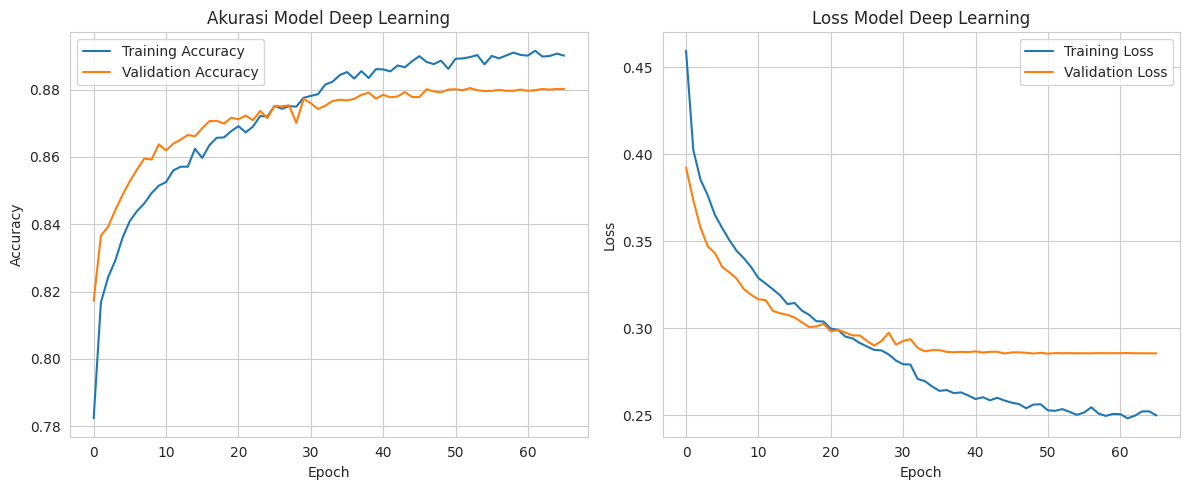

In [28]:
# Plotting
history_df = pd.DataFrame(result.history)
plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model Deep Learning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss Model Deep Learning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Performa Model Deep Learning

Sebagai perbandingan, sebuah model Jaringan Saraf Tiruan (ANN) juga dibangun.

* Arsitektur & Pelatihan: Model ini memiliki arsitektur yang cukup dalam dengan tiga lapisan tersembunyi (`Dense` 256 neuron) dan `Dropout` untuk regularisasi. Penggunaan `callbacks` seperti `EarlyStopping` dan `ReduceLROnPlateau` adalah praktik terbaik untuk mencegah overfitting dan membantu model menemukan konvergensi yang baik.

* Hasil: Model Deep Learning mencapai performa yang sangat baik, dengan F1-Score 0.91 untuk kelas "Not_Canceled" dan akurasi keseluruhan 0.88.

* Visualisasi Pelatihan: Kurva akurasi dan loss menunjukkan bahwa model belajar dengan baik. Kurva validasi mengikuti kurva pelatihan dengan cukup dekat, yang menandakan tidak adanya overfitting yang parah, berkat penggunaan `Dropout` dan `EarlyStopping`.

* Perbandingan dengan ML: Meskipun performanya kuat, model Deep Learning ini sedikit di bawah Random Forest dan XGBoost. Ini adalah temuan umum pada banyak masalah klasifikasi dengan data tabular terstruktur. Model berbasis tree seringkali lebih unggul atau setidaknya sangat kompetitif dengan effort yang lebih minimal untuk tuning.

# Kesimpulan dan Model Terbaik

Berdasarkan analisis F1-Score yang merupakan metrik paling relevan, model Random Forest (dengan parameter default) adalah model terbaik untuk proyek ini. Model ini berhasil mencapai F1-Score ~0.93, yang menunjukkan keseimbangan yang sangat baik antara kemampuan mengidentifikasi reservasi yang benar-benar tidak dibatalkan (precision) dan kemampuan untuk tidak melewatkan reservasi yang seharusnya tidak dibatalkan (recall).

Keunggulan Random Forest di sini kemungkinan besar disebabkan oleh kemampuannya untuk:

* Menangkap interaksi kompleks dan non-linear antar fitur.

* Bekerja dengan baik pada kombinasi fitur numerik dan kategorikal.

* Secara inheren tahan terhadap overfitting karena sifat ensemble-nya.

**Potensi Peningkatan**

Proyek ini sudah cukup baik, namun ada beberapa area yang bisa dieksplorasi lebih lanjut:

1. **Feature Engineering**: Menciptakan fitur baru, seperti total lama menginap (`no_of_weekend_nights` + `no_of_week_nights`) atau rasio pembatalan per tamu (`no_of_previous_cancellations` / `no_of_previous_bookings_not_canceled`).

**Model Lain**: Mencoba model gradient boosting lain seperti LightGBM atau CatBoost yang seringkali lebih cepat dan terkadang lebih akurat dari XGBoost.

`Interpretasi Model`: Menggunakan teknik seperti SHAP (SHapley Additive exPlanations) pada model Random Forest terbaik untuk memahami fitur mana yang paling berpengaruh dalam prediksi pembatalan.